Graph with combination U1=0


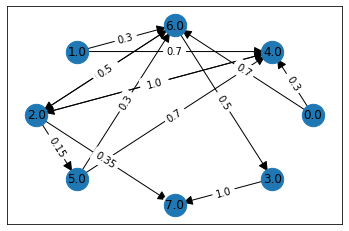

Graph with combination U1=1


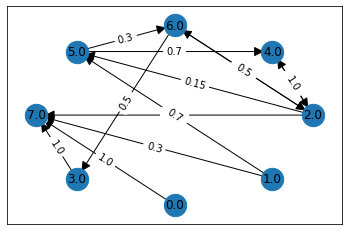

0.67 % complete.
1.33 % complete.
2.0 % complete.
2.67 % complete.
3.33 % complete.
4.0 % complete.
4.67 % complete.
5.33 % complete.
6.0 % complete.
6.67 % complete.
7.33 % complete.
8.0 % complete.
8.67 % complete.
9.33 % complete.
10.0 % complete.
10.67 % complete.
11.33 % complete.
12.0 % complete.
12.67 % complete.
13.33 % complete.
14.0 % complete.
14.67 % complete.
15.33 % complete.
16.0 % complete.
16.67 % complete.
17.33 % complete.
18.0 % complete.
18.67 % complete.
19.33 % complete.
20.0 % complete.
20.67 % complete.
21.33 % complete.
22.0 % complete.
22.67 % complete.
23.33 % complete.
24.0 % complete.
24.67 % complete.
25.33 % complete.
26.0 % complete.
26.67 % complete.
27.33 % complete.
28.0 % complete.
28.67 % complete.
29.33 % complete.
30.0 % complete.
30.67 % complete.
31.33 % complete.
32.0 % complete.
32.67 % complete.
33.33 % complete.
34.0 % complete.
34.67 % complete.
35.33 % complete.
36.0 % complete.
36.67 % complete.
37.33 % complete.
38.0 % complete.
38.67 %

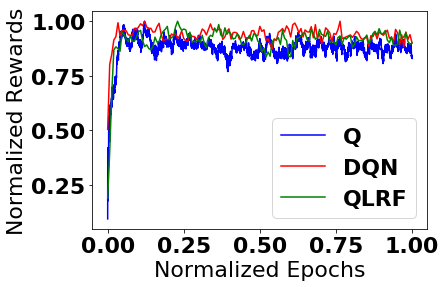

In [89]:
# Import libraries required for PBCN problem
import itertools
import pandas as pd
import pylab as plt
import networkx as nx
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import random as rd
import matplotlib.pyplot as plt
import time

# ---------------------->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Creating PBCN Parameters <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<----------------------------

ns = 3 # Number of State variables
nc = 1 # Number of Control variables
n = ns + nc # Total variables

# Generate table of all possible binary combinations between states-action pairs
table = list(itertools.product([0, 1], repeat=n))

# function to convert boolean to decimal values
def bool2dec(table_name,n_val,table_len,flag):
  dec_value=np.zeros(table_len)
  for i in range(0,table_len):
    for j in range(0,n_val):
      if flag==0:             # flag defines if control u is taken into consideration or not
        dec_value[i]=(np.power(2,(n_val-j-1)))*table_name[i][j+nc]+dec_value[i]
      else:
        dec_value[i]=(np.power(2,(n_val-j-1)))*table_name[i][j]+dec_value[i]
  return dec_value

value=bool2dec(table,ns,len(table),0)
df=pd.DataFrame([table[0:len(table)],value]) # Dataframe comprising of state-action pairs and corresponding decimal values

no_of_perm = 4 # no of possible permutations in reference to states possessing sub network structure
no_of_vars_with_diff_paths = 2 # no of variables possesing sub networks
f = np.zeros([ns+int(no_of_perm/no_of_vars_with_diff_paths),df.shape[1]]) # f=[[f11f21f31],[f11f22f31],[f12f21f31]...] all possible dynamical functions

for i in range(0,df.shape[1]):
  f[0,i]=(1-df[i][0][1]) or df[i][0][3]                   # f11 = ~x1 or x3
  f[1,i]=df[i][0][1] or df[i][0][3] or df[i][0][0]        # f21 = x1 or x3 or u
  f[2,i]=df[i][0][2] or (1-df[i][0][3])                   # f22 = x1 or ~x3
  f[3,i]=(df[i][0][2] and df[i][0][3]) or df[i][0][0]     # f31 = (x2 and x3) or u
  f[4,i]=df[i][0][2] or df[i][0][0]                       # f32 = x2 or u

# creating and storing dataframes for individual sub networks
dummy_df=pd.DataFrame([f[0,:],f[1,:],f[3,:]])
df2=pd.DataFrame([f[0,:],f[1,:],f[3,:],bool2dec(dummy_df,ns,df.shape[1],1)])     # subnetwork with combination: sc1 = f11,f21,f31
dummy_df=pd.DataFrame([f[0,:],f[2,:],f[3,:]])
df3=pd.DataFrame([f[0,:],f[2,:],f[3,:],bool2dec(dummy_df,ns,df.shape[1],1)])     # subnetwork with combination: sc2 = f11,f22,f31
dummy_df=pd.DataFrame([f[0,:],f[1,:],f[4,:]])
df4=pd.DataFrame([f[0,:],f[1,:],f[4,:],bool2dec(dummy_df,ns,df.shape[1],1)])     # subnetwork with combination: sc3 = f11,f21,f32
dummy_df=pd.DataFrame([f[0,:],f[2,:],f[4,:]])
df5=pd.DataFrame([f[0,:],f[2,:],f[4,:],bool2dec(dummy_df,ns,df.shape[1],1)])     # subnetwork with combination: sc4 = f11,f22,f32

pc = np.ones(f.shape[0])
pc[0]=1.0   # probability with combination: x1
pc[1]=0.3   # probability with combination: x2, f21
pc[2]=0.7   # probability with combination: x2, f22
pc[3]=0.5   # probability with combination: x3, f31
pc[4]=0.5   # probability with combination: x3, f32

points_list_U1=list()   # transitions in decimal form with control u = 0
points_list_U2=list()   # transitions in decimal form with control u = 1
edge_weights_U1={}      # probabilities of transitions with control u = 0
edge_weights_U2={}      # probabilities of transitions with control u = 1

# notations indicating control chosen
control_dict={0:"u=0",
             1:"u=1",
            -1:"No Control"}

c = np.power(2,nc)
for i in range(0,np.power(2,ns)):                                                 # transitions are calculated in reference to the underlying dynamical equations and corresponding probabilities are stored
  points_list_U1.append((df[i][1],df2[i][3]))
  edge_weights_U1[points_list_U1[-1]]=str(np.round(pc[0]*pc[1]*pc[3],2))
  points_list_U1.append((df[i][1],df3[i][3]))
  if points_list_U1[-1] in points_list_U1[0:len(points_list_U1)-1]:
    edge_weights_U1[points_list_U1[-1]]=str(float(edge_weights_U1[points_list_U1[-1]])+np.round(pc[0]*pc[2]*pc[3],2))
  else:
    edge_weights_U1[points_list_U1[-1]]=str(np.round(pc[0]*pc[2]*pc[3],2))
  points_list_U1.append((df[i][1],df4[i][3]))
  if points_list_U1[-1] in points_list_U1[0:len(points_list_U1)-1]:
    edge_weights_U1[points_list_U1[-1]]=str(float(edge_weights_U1[points_list_U1[-1]])+np.round(pc[0]*pc[1]*pc[4],2))
  else:
    edge_weights_U1[points_list_U1[-1]]=str(np.round(pc[0]*pc[1]*pc[4],2))
  points_list_U1.append((df[i][1],df5[i][3]))
  if points_list_U1[-1] in points_list_U1[0:len(points_list_U1)-1]:
    edge_weights_U1[points_list_U1[-1]]=str(float(edge_weights_U1[points_list_U1[-1]])+np.round(pc[0]*pc[2]*pc[4],2))
  else:
    edge_weights_U1[points_list_U1[-1]]=str(np.round(pc[0]*pc[2]*pc[4],2))

  points_list_U2.append((df[i+c][1],df2[i+c][3]))
  edge_weights_U2[points_list_U2[-1]]=str(np.round(pc[0]*pc[1]*pc[3],2))
  points_list_U2.append((df[i+c][1],df3[i+c][3]))
  if points_list_U2[-1] in points_list_U2[0:len(points_list_U2)-1]:
    edge_weights_U2[points_list_U2[-1]]=str(float(edge_weights_U2[points_list_U2[-1]])+np.round(pc[0]*pc[2]*pc[3],2))
  else:
    edge_weights_U2[points_list_U2[-1]]=str(np.round(pc[0]*pc[2]*pc[3],2))
  points_list_U2.append((df[i+c][1],df4[i+c][3]))
  if points_list_U2[-1] in points_list_U2[0:len(points_list_U2)-1]:
    edge_weights_U2[points_list_U2[-1]]=str(float(edge_weights_U2[points_list_U2[-1]])+np.round(pc[0]*pc[1]*pc[4],2))
  else:
    edge_weights_U2[points_list_U2[-1]]=str(np.round(pc[0]*pc[1]*pc[4],2))
  points_list_U2.append((df[i+c][1],df5[i+c][3]))
  if points_list_U2[-1] in points_list_U2[0:len(points_list_U2)-1]:
    edge_weights_U2[points_list_U2[-1]]=str(float(edge_weights_U2[points_list_U2[-1]])+np.round(pc[0]*pc[2]*pc[4],2))
  else:
    edge_weights_U2[points_list_U2[-1]]=str(np.round(pc[0]*pc[2]*pc[4],2))
    

# function to calculate possible attractors of the given PBCN
def find_Attractors(G,nx):
  number_of_attractor = nx.number_attracting_components(G)
  a_list = list(nx.attracting_components(G))
  return a_list

# Visualizing the graphs for u = 0
print("Graph with combination U1=0")
GU1=nx.DiGraph()
GU1.add_edges_from(points_list_U1)
posU1=nx.circular_layout(GU1)
nx.draw_networkx_nodes(GU1,posU1,node_size=500)
nx.draw_networkx_edges(GU1,posU1,arrowstyle='-|>',arrowsize=20,arrows=True)
nx.draw_networkx_labels(GU1,posU1)
nx.draw_networkx_edge_labels(GU1,posU1,edge_labels=edge_weights_U1)
plt.show()

# Calculating and saving attractors for individual control actions
attractor_set = []
a_calc = find_Attractors(GU1,nx)
attractor_set.append(a_calc)

# Visualizing the graphs for u = 1
print("Graph with combination U1=1")
GU2=nx.DiGraph()
GU2.add_edges_from(points_list_U2)
posU2=nx.circular_layout(GU2)
nx.draw_networkx_nodes(GU2,posU2,node_size=500)
nx.draw_networkx_edges(GU2,posU2,arrowstyle='-|>',arrowsize=20,arrows=True)
nx.draw_networkx_labels(GU2,posU2)
nx.draw_networkx_edge_labels(GU2,posU2,edge_labels=edge_weights_U2)
plt.show()

a_calc = find_Attractors(GU2,nx)
if a_calc not in attractor_set:
  attractor_set.append(a_calc)

# Creating probability transition matrices for existent sub networks.
probs_U1=np.zeros([np.power(2,ns),np.power(2,ns)])
probs_U2=np.zeros([np.power(2,ns),np.power(2,ns)])
for i in range(len(points_list_U1)):
  probs_U1[int(points_list_U1[i][0])][int(points_list_U1[i][1])]=edge_weights_U1[points_list_U1[i]]
  probs_U2[int(points_list_U2[i][0])][int(points_list_U2[i][1])]=edge_weights_U2[points_list_U2[i]]


# ---------------------->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Creating PBCN Parameters <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<----------------------------

# ---------------------->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Defining and implementing RL control <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<----------------------------

# Model-free Reinforcement Learning

# Define parameters required for Q-learning
num_nodes=np.power(2,ns)
initial_state=np.random.choice(range(num_nodes-1))
goal=7                                              # desired attractor: 111-1 or decimal-7
gamma=0.9                                           # discount factor: \gamma \in [0,1)
lr=0.3                                              # learning rate: \alpha \in (0,1]
EPSILON=0.1                                         # initialising \epsilon in \eplsion-greedy policy

# Environment variables
PTM=np.stack((probs_U1,probs_U2))                   # Defining probability transitions matrix
proportional_factor = 1.0                           # Proportionality factor for creating rewards
R = proportional_factor*PTM                         # Rewards given by the environment

# assign maximum reward of 100 to possible paths that lead to desired attractor
for j in range(PTM.shape[0]):
  for i in range(PTM.shape[1]):
    for k in range(PTM.shape[2]):
      if PTM[j,i,k]!=0 and k == goal:
        R[j,i,k]=100

# Model-free Controller using Q-learning
Q=np.zeros([np.power(2,ns),np.power(2,nc)]) # Initialize Q table to zeros with dimensions defined by states-action pairs

def Q_learning(current_state, current_action, next_state, gamma):
  max_index=np.squeeze(np.where(Q[int(current_state),:]==np.max(Q[int(current_state),:])))      # a*=\underset{a \in A(s)}{\arg \max}(Q(s,a))

  if max_index.size > 1:
      max_index = int(np.random.choice(max_index, size = 1))
  else:
      max_index = int(max_index)
  max_value = Q[int(next_state), max_index]                   # Q* = Q(s',a*)
  
  # Q(s,a) \leftarrow [Q(s,a) + \alpha(R + \gamma Q* - Q(s,a))]
  Q[int(current_state), int(current_action)] = (Q[int(current_state), int(current_action)] + lr*(R[int(current_action), int(current_state), int(next_state)] + gamma * max_value - Q[int(current_state), int(current_action)]))

  # Store normalized score of overall Q matrix as MDP
  if (np.max(Q) > 0):
    return((np.sum(Q/np.max(Q)*100)))     # score = \sum \frac{Q}{\max Q}
  else:
    return((0))

Q_algo=[]     # Initialize a dummy Q as a placholder in greedy algo for Q, DQN and QLRF
def greedy_policy(state,Q_algo):
  action_prob = np.ones(np.power(2,nc))*EPSILON/np.power(2,nc)      # define action probabilities as \epsilon/|A(s)|
  best_action = np.array([np.argmax(Q_algo[state,:])])              # choose best action to be a*=\underset{a\in A(s)}{\arg \max} Q
  if best_action.shape[0]>1:
    best_action = np.random.choice(best_action,size=1)
  action_prob[best_action]+=(1-EPSILON)                             # for a* set action probability = \epsilon/|A(s)| + (1-\epsilon)
  return action_prob

# Define environment as: [current_state, next_state, action, reward] = env(current_state, Q_algo), where Q_algo is either Q, DQN or QLRF.
def env(current_state,Q_algo):
  action_probabilities = greedy_policy(current_state,Q_algo)                                  # calculate action probabilities using greedy policy
  action = np.random.choice(np.arange(len(action_probabilities)), p = action_probabilities)   # calculate action
  if action.size > 1:                                     # if there are multiple actions choose any one randomly and for the chosen random action, choose single next_state if multiple transitions are possible
    action = int(np.random.choice(action,size=1))
    next_state = int(np.squeeze(np.where(PTM[action,current_state,:]>0)))
    if next_state.size>1:
      next_state = int(np.random.choice(np.squeeze(np.where(PTM[action,current_state,:]>0)),size=1))
    else:
      next_state = int(np.squeeze(np.where(PTM[action,current_state,:]>0)))
  else:
    next_state = np.squeeze(np.where(PTM[action,current_state,:]>0))
    if next_state.size>1:
      next_state = int(np.random.choice(np.squeeze(np.where(PTM[action,current_state,:]>0)),size=1))
    else:
      next_state = int(np.squeeze(np.where(PTM[action,current_state,:]>0)))
  reward = R[action,current_state,next_state]

  return np.array([current_state,next_state,action,reward])

# intitalize Q values using random initial state
action_probabilities = greedy_policy(initial_state,Q)
action = np.random.choice(np.arange(len(action_probabilities)), p = action_probabilities) 
if action.size > 1:
  action = int(np.random.choice(action,size=1))
  next_state = int(np.squeeze(np.where(PTM[action,initial_state,:]>0))[0])
else:
  next_state = np.squeeze(np.where(PTM[action,initial_state,:]>0))
  if next_state.size>1:
    next_state = int(np.random.choice(np.squeeze(np.where(PTM[action,initial_state,:]>0)),size=1))
  else:
    next_state = int(np.squeeze(np.where(PTM[action,initial_state,:]>0)))
score_Q=Q_learning(initial_state, action, next_state, gamma)

# set a seed for rehearsing the results
seed = 0
np.random.seed(seed)

# QLRF algorithm
def QLRF(RANDOM_TRANSITIONS_DATA_buff):
  
  Q_pred_qrf = np.zeros(Q.shape)                                        # Initialize Q to zeros
    
  # generate D=(xn,yn) from state-action-value pairs from replay buffer
  data_buff = np.asarray(RANDOM_TRANSITIONS_DATA_buff)
  X = np.array([list(item) for item in np.array(data_buff[:,2])])
  y = np.array(data_buff[:,3])
  y = y.reshape((y.shape[0], 1))
  y_ind=np.where(y!=0)[0]                                               # remove 0 entries to avoid bad-data predictions
  yn=y[y_ind]
  Xn=X[y_ind,:]

  # Standardized the data for good predictions
  sc=StandardScaler()
  X=sc.fit_transform(Xn)
  Y=yn.reshape(-1,1)
  Y=sc.fit_transform(Y)

  # Split the data into training and test sets and fit random forest model from sklearn
  train_X, val_X, train_y, val_y = train_test_split(X, Y, test_size = 0.25, random_state = 14)
  regressor = RandomForestRegressor(n_estimators=20, random_state=0)
  regressor.fit(train_X, train_y.ravel())

  # generate predictions using fitted random forest model and use inverse transform to generate unscaled original values
  y_pred = regressor.predict(X)
  y_pred = y_pred.reshape(-1,1)
  y_pred=sc.inverse_transform(y_pred)

  # remove rewards lower than or higher than a certain threshold in order to avoid bad predictions
  for k in range(len(y_pred)):
    if (y_pred[k]>REWARD_LB) and (y_pred[k]<=REWARD_UB):
      Q_pred_qrf[int(data_buff[k,0]),int(data_buff[k,1])] = y_pred[k]
  
  return Q_pred_qrf

# Function to create a model for KerasRegressor with single hidden layer, activated using 'linear' activations function and minimising SGD MSE.
def create_model():
    # Create a model
    model = Sequential()
    model.add(Dense(2, input_dim=ns, kernel_initializer='normal', activation='linear'))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='SGD', metrics=['mse'])
    return model


def dQn(RANDOM_TRANSITIONS_DATA_buff):

  Q_pred_dqn = np.zeros(Q.shape)                                     # Initialize Q to zeros

  # generate D=(xn,yn) from state-action-value pairs from replay buffer
  data_buff = np.asarray(RANDOM_TRANSITIONS_DATA_buff)
  X = np.array([list(item) for item in np.array(data_buff[:,2])])
  y = np.array(data_buff[:,3])
  y = y.reshape((y.shape[0], 1))
  y_ind=np.where(y!=0)[0]                                               # remove 0 entries to avoid bad-data predictions
  yn=y[y_ind]
  Xn=X[y_ind,:]

  # Standardized the data for good predictions
  sc = StandardScaler()
  X = sc.fit_transform(Xn)
  y = yn.reshape((yn.shape[0], 1))
  Y = sc.fit_transform(y)

  # Split the data into training and test sets and fit DNN model from sklearn
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=14)
  estimator=KerasRegressor(build_fn=create_model, epochs=200, batch_size=10, verbose=0)
  results=estimator.fit(X_train,y_train)
  
  # generate predictions using fitted DNN model and use inverse transform to generate unscaled original values
  y_pred=estimator.predict(X)
  y_pred=y_pred.reshape(-1,1)
  y_pred=sc.inverse_transform(y_pred)

  # remove rewards lower than or higher than a certain threshold in order to avoid bad predictions
  for k in range(len(y_pred)):
    if (y_pred[k]>REWARD_LB) and (y_pred[k]<=REWARD_UB):
      Q_pred_dqn[int(data_buff[k,0]),int(data_buff[k,1])] = y_pred[k]

  return Q_pred_dqn

# ------------------------>>>>>>>>>>>>>>>>> Training Module <<<<<<<<<<<<<<<<----------------------------
start_time = time.time()                                            # start the timer to time overall code execution for all the three algorithms to train

# Initialize overall normalized score for all the three algorithms
scores_Q = []
scores_DQN = []
scores_QLRF = []
# Initialize predict (Q) and target (\hat{Q}) for DQN
Q_target_DQN = np.zeros([np.power(2,ns),np.power(2,nc)])
Q_predict_DQN = np.zeros([np.power(2,ns),np.power(2,nc)])
# Initialize predict (Q) and target (\hat{Q}) for QRLF
Q_target_QLRF = np.zeros([np.power(2,ns),np.power(2,nc)])
Q_predict_QLRF = np.zeros([np.power(2,ns),np.power(2,nc)])
# Define parameters for exploration-exploitation type learning starting from complete exploration to near exploitation of target Q values.
EPSILON = 1.0
EPSILON_DECAY_RATE = 0.95
EPSILON_MIN = 0.05
# set maximum replay buffer capacity or RB_{cap}
REPLAY_BUFFER_MAX = 200
# set number of parameters to be stored in replay buffer; i.e., current_state, next_state, action, reward
no_of_params_RB = 4
# initialize replay buffers for both DQN and QLRF
REPLAY_BUFFER_DQN = np.zeros([REPLAY_BUFFER_MAX,no_of_params_RB])
REPLAY_BUFFER_QLRF = np.zeros([REPLAY_BUFFER_MAX,no_of_params_RB])
# set maximum iterations to train and batch size to be sampled
MAX_ITER = 30000
BATCH = 100
# initialize randomly sampled dataset for both the algorithms
RANDOM_TRANSITIONS_DQN = 0
RANDOM_TRANSITIONS_QLRF = 0
# # define number of parameters for random transitions dataset; i.e., 
# no_of_params_RT = 3
# define upper and lower bounds on rewards achieved 
REWARD_LB = -0.1
REWARD_UB = 100
# initialize random transitions dataset D_i \in random_transitions dataset D according to defined batch size.
RANDOM_TRANSITIONS_DATA = []
RANDOM_TRANSITIONS_DATA2 = []
# initialize targets for DQN and QLRF
TARGET = np.zeros([BATCH,1])
TARGET2 = np.zeros([BATCH,1])
# initialize losses for DQN and QLRF
LOSS = np.zeros([BATCH,1])
LOSS2 = np.zeros([BATCH,1])
# initialize counts and state_key for corresponding boolean values
cnt = 0
idx_cnt = 0
state_key = list(itertools.product([0, 1], repeat=ns))

for i in range(MAX_ITER):
  current_state = np.random.randint(0, num_nodes)                   # choose random current_state in every iterations and generated data for training Q values
  # iteratre until replay buffer is completely filled and once the data is available train DQN and QLRF models
  if cnt%REPLAY_BUFFER_MAX==0 and cnt!=0:

    idx = np.random.randint(REPLAY_BUFFER_MAX, size=BATCH)          # choose random indexes of size batch from replay buffer
    # generate random transitions sample dataset for training
    RANDOM_TRANSITIONS_DQN = REPLAY_BUFFER_DQN[idx,:]
    RANDOM_TRANSITIONS_QLRF = REPLAY_BUFFER_QLRF[idx,:]

    # for all the values in random transitions dataset train DQN and QLRF models
    for j in range(BATCH):
      # if state == terminal: --> target = reward else: --> target = r+\gamma \underset{a \in A(s)}{\arg \max} Q(s,a)
      if RANDOM_TRANSITIONS_DQN[j,1] == goal:
        TARGET[j] = R[int(RANDOM_TRANSITIONS_DQN[j,2]),int(RANDOM_TRANSITIONS_DQN[j,0]),int(RANDOM_TRANSITIONS_DQN[j,1])]
      else:
        max_index=np.squeeze(np.where(Q_target_DQN[current_state,:]==np.max(Q_target_DQN[current_state,:])))

        if max_index.size > 1:
            max_index = int(np.random.choice(max_index, size = 1))
        else:
            max_index = int(max_index)
        max_value = Q_target_DQN[int(RANDOM_TRANSITIONS_DQN[j,1]), max_index]
        TARGET[j] = R[int(RANDOM_TRANSITIONS_DQN[j,2]),int(RANDOM_TRANSITIONS_DQN[j,0]),int(RANDOM_TRANSITIONS_DQN[j,1])] + gamma*(max_value)
        
      # if state == terminal: --> target = reward else: --> target = r+\gamma \underset{a \in A(s)}{\arg \max} Q(s,a)
      if RANDOM_TRANSITIONS_QLRF[j,1] == goal:
        TARGET2[j] = R[int(RANDOM_TRANSITIONS_QLRF[j,2]),int(RANDOM_TRANSITIONS_QLRF[j,0]),int(RANDOM_TRANSITIONS_QLRF[j,1])]
      else:
        max_index2=np.squeeze(np.where(Q_target_QLRF[current_state,:]==np.max(Q_target_QLRF[current_state,:])))

        if max_index2.size > 1:
            max_index2 = int(np.random.choice(max_index2, size = 1))
        else:
            max_index2 = int(max_index2)
        max_value2 = Q_target_QLRF[int(RANDOM_TRANSITIONS_QLRF[j,1]), max_index2]
        TARGET2[j] = R[int(RANDOM_TRANSITIONS_QLRF[j,2]),int(RANDOM_TRANSITIONS_QLRF[j,0]),int(RANDOM_TRANSITIONS_QLRF[j,1])] + gamma*(max_value2)
      
      # LOSS = \sum (Q_predicted-Target)^2
      # random transitions data comprises of current_state, action , binary key for transitions, target, LOSS.
      LOSS[j]=np.sum(np.power(Q_predict_DQN[int(RANDOM_TRANSITIONS_DQN[j,0]),int(RANDOM_TRANSITIONS_DQN[j,2])]-TARGET[j],2))
      RANDOM_TRANSITIONS_DATA.append(np.array([RANDOM_TRANSITIONS_DQN[j,0],RANDOM_TRANSITIONS_DQN[j,2],state_key[int(RANDOM_TRANSITIONS_DQN[j,0])],float(TARGET[j]),float(LOSS[j])]))

      # LOSS = \sum (Q_predicted-Target)^2
      # random transitions data comprises of current_state, action , binary key for transitions, target, LOSS.
      LOSS2[j]=np.sum(np.power(Q_predict_QLRF[int(RANDOM_TRANSITIONS_QLRF[j,0]),int(RANDOM_TRANSITIONS_QLRF[j,2])]-TARGET2[j],2))
      RANDOM_TRANSITIONS_DATA2.append(np.array([RANDOM_TRANSITIONS_QLRF[j,0],RANDOM_TRANSITIONS_QLRF[j,2],state_key[int(RANDOM_TRANSITIONS_QLRF[j,0])],float(TARGET2[j]),float(LOSS2[j])]))
    
    # predict Q values using DQN algorithms
    Q_predict_DQN = dQn(RANDOM_TRANSITIONS_DATA)
    for l in range(Q_predict_DQN.shape[0]):
      for k in range(Q_predict_DQN.shape[1]):
        if Q_predict_DQN[l,k]!=0:                   # update target Q values using newer values in predict Q values and avoid bad predictions
          Q_target_DQN[l,k] = Q_predict_DQN[l,k]

    # predict Q values using QLRF algorithms
    Q_predict_QLRF = QLRF(RANDOM_TRANSITIONS_DATA2)
    for l in range(Q_predict_QLRF.shape[0]):
      for k in range(Q_predict_QLRF.shape[1]):
        if Q_predict_QLRF[l,k]!=0:                  # update target Q values using newer values in predict Q values and avoid bad predictions
          Q_target_QLRF[l,k] = Q_predict_QLRF[l,k] 

    # reduce epsilon every training step so as to maintain exploration-exploitation
    if EPSILON >= EPSILON_MIN:
      EPSILON*=EPSILON_DECAY_RATE

    # flush all the data from replay buffer and randomly sampled dataset
    idx_cnt = 0
    REPLAY_BUFFER_DQN = np.zeros([REPLAY_BUFFER_MAX,no_of_params_RB])
    REPLAY_BUFFER_QLRF = np.zeros([REPLAY_BUFFER_MAX,no_of_params_RB])
    RANDOM_TRANSITIONS_DATA = []
    RANDOM_TRANSITIONS_DATA2 = []

    # calculate normalized rewards or scores for individual algorithms
    if (np.max(Q_target_DQN) > 0):
      scores_pred = ((np.sum(Q_target_DQN/np.max(Q_target_DQN)*100)))
    else:
      scores_pred=0
    scores_DQN.append(scores_pred)

    if (np.max(Q_target_QLRF) > 0):
      scores_pred = ((np.sum(Q_target_QLRF/np.max(Q_target_QLRF)*100)))
    else:
      scores_pred=0
    scores_QLRF.append(scores_pred)

    # print overall progress of the training process.
    print(np.round((i/MAX_ITER)*100,2),'% complete.')
  
  else:

    # generate replay buffers for DQN and QLRF learning
    REPLAY_BUFFER_DQN[idx_cnt,:] = env(current_state,Q_target_DQN)
    REPLAY_BUFFER_QLRF[idx_cnt,:] = env(current_state,Q_target_QLRF)
    idx_cnt += 1

    # populate Q values in Q-learning and generate normalized score for evaluation
    [current_state,next_state,action,reward] = env(current_state,Q)
    score_Q = Q_learning(current_state,action,next_state,gamma)
    scores_Q.append(score_Q)

  cnt+=1                                                                    # count for checking replay buffer data

# print total time taken for the overall training
print('Total time taken for training of all the three algorithms')
print("--- %s seconds ---" % (time.time() - start_time))

# generate normalized score from successive steps for peer-to-peer comparisons
scores_Q = scores_Q/np.max(scores_Q)
scores_DQN = scores_DQN/np.max(scores_DQN)
scores_QLRF = scores_QLRF/np.max(scores_QLRF)

# generate a linear x-space for plotting
t1 = np.linspace(0, 1, len(scores_Q))
t2 = np.linspace(0, 1, len(scores_DQN))
t3 = np.linspace(0, 1, len(scores_QLRF))

# visualize the data
plt.plot(t1, scores_Q, label='Q', color = 'blue')
plt.plot(t2, scores_DQN, label='DQN', color = 'red')
plt.plot(t3, scores_QLRF, label='QLRF', color = 'green')
plt.xlabel('Normalized Epochs')
plt.ylabel('Normalized Rewards')
plt.legend()
plt.show()

# ------------------------>>>>>>>>>>>>>>>>> Training Module <<<<<<<<<<<<<<<<----------------------------

# ---------------------->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Defining and implementing RL control <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<----------------------------


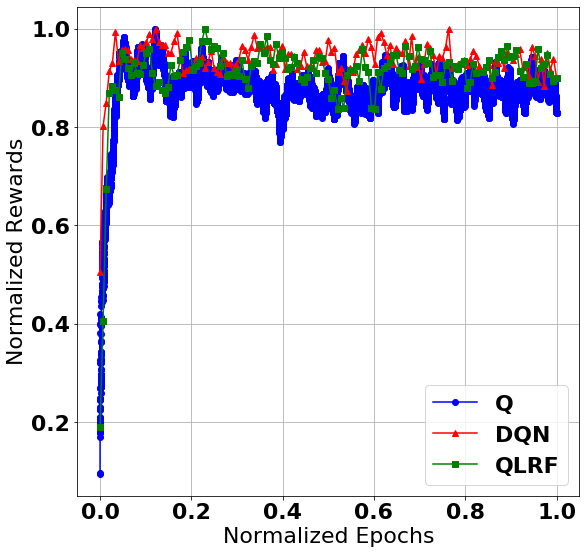

In [90]:
# Visualize data using wider figures
t1 = np.linspace(0, 1, len(scores_Q))
t2 = np.linspace(0, 1, len(scores_DQN))
t3 = np.linspace(0, 1, len(scores_QLRF))

fig = plt.figure(figsize=(9, 9))
plt.rcParams.update({'font.size': 22, 'font.weight':'bold'})
plt.plot(t1, scores_Q, label='Q', color = 'blue', marker='o')
plt.plot(t2, scores_DQN, label='DQN', color = 'red', marker='^')
plt.plot(t3, scores_QLRF, label='QLRF', color = 'green', marker='s')
plt.xlabel('Normalized Epochs')
plt.ylabel('Normalized Rewards')
plt.legend()
plt.grid()
plt.show()

In [102]:
# Generate heat-maps for analysis
crms=np.transpose(Q_target_QLRF)

np.random.seed(24)
df_dummy = pd.DataFrame({'Q': np.linspace(0, 1, 2)})
df_dummy = pd.concat([df_dummy, pd.DataFrame(crms)],axis=1)

import seaborn as sns

cm = sns.light_palette("blue", as_cmap=True)

s5 = df_dummy.style.background_gradient(cmap=cm)
s5

,Q,0,1,2,3,4,5,6,7
0,0,72.688,59.4449,71.2611,100,65.135,54.4999,68.0648,100
1,1,72.688,57.1632,67.9517,100,58.2955,63.3126,79.5558,100


In [105]:
# ------------------------>>>>>>>>>>>>>>>>> Testing Module <<<<<<<<<<<<<<<<----------------------------
current_state = np.random.randint(0,num_nodes)
initial_state = current_state
steps = [current_state]
steps_actions = []
goal = 7

# Use optimal policy from Q calculated using Q, DQN, QLRF and check efficacy of the algorithms
Q_algo = Q_target_QLRF
while (current_state != goal):

    action = np.squeeze(np.where(Q_algo[int(current_state),:] == np.max(Q_algo[int(current_state),:])))

    if action.size > 1:
      action = int(np.random.choice(action,size=1))
      next_state = np.squeeze(np.where(PTM[action,int(current_state),:]>0))
      if next_state.size>1:
        next_state = int(np.random.choice(np.squeeze(np.where(PTM[int(action),int(current_state),:]>0)),size=1))
      else:
        next_state = int(np.squeeze(np.where(PTM[int(action),int(current_state),:]>0)))
    else:
      next_state = np.squeeze(np.where(PTM[int(action),int(current_state),:]>0))
      if next_state.size>1:
        next_state = int(np.random.choice(np.squeeze(np.where(PTM[int(action),int(current_state),:]>0)),size=1))
      else:
        next_state = int(np.squeeze(np.where(PTM[int(action),int(current_state),:]>0)))   
    
    steps.append(next_state)
    current_state = next_state

    steps_actions.append(action)

print("------------------------->>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<<<--------------------")
print("Applying Q-learning based control")
print("This example starts with ",initial_state," and ends in ",goal)
for i in range(len(steps)-1):
  print("Current Node: ",steps[i])
  if i!=len(steps)-1:
    print("Current Control Action: ",control_dict[int(steps_actions[i])])

print(steps[-1])
print("------------------------->>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<<<--------------------")

# ------------------------>>>>>>>>>>>>>>>>> Testing Module <<<<<<<<<<<<<<<<----------------------------

------------------------->>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<<<--------------------
Applying Q-learning based control
This example starts with  1  and ends in  7
Current Node:  1
Current Control Action:  u=0
Current Node:  6
Current Control Action:  u=1
Current Node:  3
Current Control Action:  u=0
7
------------------------->>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<<<--------------------
